In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx

G = nx.DiGraph() 

In [2]:
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 1],[0, 0, 0, 0, 1, 0]])
print(A)

[[0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 1 0]]


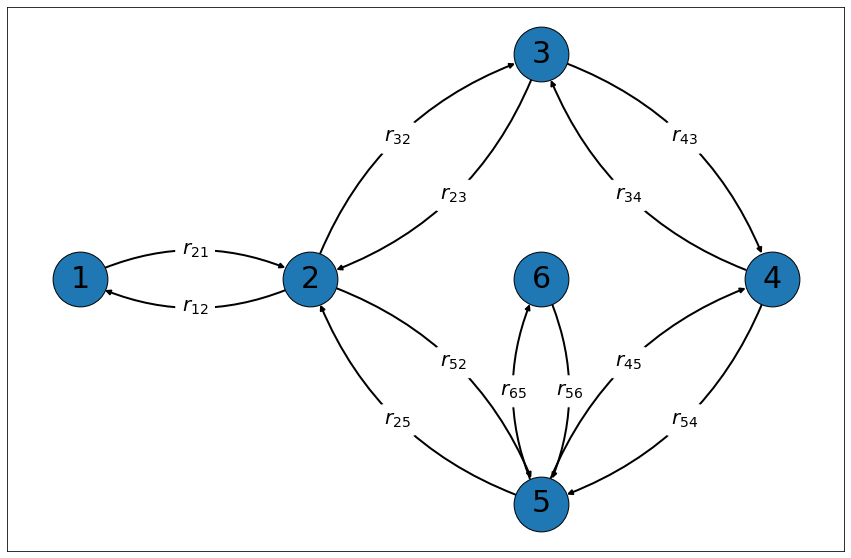

In [3]:
def plot_network(A, w=np.ones_like(A), position={1:(0,0),2:(1,0),3:(2,1),4:(3,0),5:(2,-1),6:(2,0)}, name="figures/Example_Calmodulin_1.pdf"):
    edges = []

    for i in range(6): 
        for j in range(6): 
            if A[i, j] == 1: 
                #G.add_edge(i,j)
                edges.append((i+1, j+1, {"w":r"$r_{%d%d}$" % (i+1, j+1)}))
        G.add_node(i+1)

    G.add_edges_from(edges)


    fixed_positions = position #dict with two of the positions set
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

    node_sizes = [3 + 10 * i for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    cmap = plt.cm.plasma

    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=3000, edgecolors="k")
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=30)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges, arrowstyle="<|-", width=5, node_size=3000)
    arc_rad = 0.25
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle="<|-", width=2, node_size=3000)

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=20)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)
    plt.savefig(name, dpi=500, bbox_inches="tight")

plot_network(A)

In [4]:
def printMatrix(s):
    
    for i in range(len(s)):
        for j in range(len(s[0])):
            print("%f   " % (s[i][j]), end="")
        print("\n") 

In [5]:
def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
        L[i, i] = - np.sum(L[i, :])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq




In [6]:
energies = rn.exponential(1, size=(6))
print(energies)

[2.33186578 3.43728651 0.94210972 2.78637239 0.07799653 1.20666756]


In [7]:
peq = np.exp(-energies)
Z = np.sum(peq)
peq = peq/Z

In [8]:
N = len(peq)
Pmatrix = np.zeros((N, N))
for i in range(N):
    Pmatrix[i, i] = np.sqrt(peq[i])

printMatrix(Pmatrix)

0.231963   0.000000   0.000000   0.000000   0.000000   0.000000   

0.000000   0.133469   0.000000   0.000000   0.000000   0.000000   

0.000000   0.000000   0.464729   0.000000   0.000000   0.000000   

0.000000   0.000000   0.000000   0.184809   0.000000   0.000000   

0.000000   0.000000   0.000000   0.000000   0.715879   0.000000   

0.000000   0.000000   0.000000   0.000000   0.000000   0.407148   



In [9]:
L = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            L[i, j] = np.exp(energies[j])
    L[i, i] = - np.sum(L[i, :])

Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))
printMatrix(Ls)


ew, ev = np.linalg.eigh(Ls)
print(ew)

D = np.matmul(ev.T, np.matmul(Ls, ev))
printMatrix(D)


-31.102447   17.895981   0.000000   0.000000   0.000000   0.000000   

17.895981   -13.943643   8.932516   0.000000   5.798745   0.000000   

0.000000   8.932516   -47.324513   6.451038   0.000000   0.000000   

0.000000   0.000000   6.451038   -3.646507   4.187837   0.000000   

0.000000   5.798745   0.000000   4.187837   -50.666841   1.900909   

0.000000   0.000000   0.000000   0.000000   1.900909   -1.081119   

[-5.43036948e+01 -4.93604172e+01 -3.97301383e+01 -3.30590144e+00
 -1.06491764e+00 -2.68287174e-15]
-54.303695   -0.000000   -0.000000   -0.000000   -0.000000   -0.000000   

-0.000000   -49.360417   0.000000   -0.000000   0.000000   0.000000   

-0.000000   0.000000   -39.730138   0.000000   0.000000   0.000000   

-0.000000   -0.000000   0.000000   -3.305901   -0.000000   -0.000000   

-0.000000   0.000000   -0.000000   -0.000000   -1.064918   0.000000   

-0.000000   0.000000   0.000000   -0.000000   0.000000   0.000000   



## Three State System

In [59]:
energies = rn.exponential(1, size=(3))
A = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq



Peq, L, Ls, peq = Matrices(energies=energies, A=A)


a = L[0, 1]
b = L[0, 2]
c = L[1, 0]
d = L[1, 2]
e = L[2, 0]
f = L[2, 1]



EWs, EVs = np.linalg.eigh(Ls)

print(np.linalg.eigh(Ls)[0])
print(np.linalg.eig(L)[0])

print(np.linalg.eig(L)[1])


printMatrix(Ls)
printMatrix(L)

print(peq)


E = np.linalg.eig(L)[0]

x = np.argmin(np.abs(E))


v = np.linalg.eig(L)[1]
v = v[:, x]
print(v, x)
print(v / peq)

[-3.12584934e+00 -2.90125497e+00  1.22731686e-16]
[ 0.         -2.90125497 -3.12584934]
[[ 0.66176907  0.80537022 -0.135284  ]
 [ 0.5498138  -0.5190213  -0.62969126]
 [ 0.50967292 -0.28634892  0.76497526]]
-1.789087   1.000000   1.000000   

1.000000   -2.059902   1.000000   

1.000000   1.000000   -2.178115   

-1.789087   1.097098   1.139482   

0.911496   -2.059902   1.038633   

0.877592   0.962804   -2.178115   

[0.38446876 0.31942597 0.29610527]
[0.66176907 0.5498138  0.50967292] 0
[1.72125579 1.72125579 1.72125579]


In [60]:
D = np.diag(EWs)


printMatrix(D)

Ds = np.matmul(EVs.T, np.matmul(Ls, EVs))

printMatrix(Ds)


print(Ds)

-3.125849   0.000000   0.000000   

0.000000   -2.901255   0.000000   

0.000000   0.000000   0.000000   

-3.125849   -0.000000   -0.000000   

-0.000000   -2.901255   0.000000   

-0.000000   0.000000   0.000000   

[[-3.12584934e+00 -1.29389350e-16 -3.74444964e-16]
 [-1.31539022e-16 -2.90125497e+00  2.83432489e-16]
 [-9.11964809e-17  2.35930450e-16  1.02388084e-16]]


In [61]:
print(EWs, -EWs)
sqrtLs = np.matmul(EVs, np.matmul(np.diag(np.sqrt(np.abs(EWs))), EVs.T)) 
printMatrix(sqrtLs)

[-3.12584934e+00 -2.90125497e+00  1.22731686e-16] [ 3.12584934e+00  2.90125497e+00 -1.22731686e-16]
1.049382   -0.592093   -0.580785   

-0.592093   1.183823   -0.554879   

-0.580785   -0.554879   1.238109   



In [62]:
scale = 0.1
A = scale * np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])


printMatrix(-np.matmul(sqrtLs, np.matmul(A, sqrtLs)))

-0.000000   -0.089171   0.092616   

0.089171   -0.000000   -0.101609   

-0.092616   0.101609   -0.000000   



In [63]:
printMatrix(-np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs)))

print(np.identity(3))

-1.789087   0.910829   1.092616   

1.089171   -2.059902   0.898391   

0.907384   1.101609   -2.178115   

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [64]:
positions = {1:(1, 0), 2:()}

In [65]:
Lneq = -np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs))#
printMatrix(Lneq)

-1.789087   0.910829   1.092616   

1.089171   -2.059902   0.898391   

0.907384   1.101609   -2.178115   



In [66]:
print(np.linalg.eig(Lneq)[0])
print(np.linalg.eig(Lneq)[1])
print(Peq)

[-1.78940629e-16+0.j         -3.01355216e+00+0.11934317j
 -3.01355216e+00-0.11934317j]
[[-0.62005545+0.j         -0.53885146-0.28556566j -0.53885146+0.28556566j]
 [-0.56517782+0.j         -0.10270755+0.31329351j -0.10270755-0.31329351j]
 [-0.54415556+0.j          0.72068696+0.j          0.72068696-0.j        ]]
[[0.62005545 0.         0.        ]
 [0.         0.56517782 0.        ]
 [0.         0.         0.54415556]]


In [67]:
print(np.matmul(Lneq, np.array([0.53117816, 0.53012983, 0.66091764])))
print(peq)
print(np.matmul(Lneq, peq))

[ 0.25466259  0.08029093 -0.37357623]
[0.38446876 0.31942597 0.29610527]
[-0.07337643  0.02678436  0.055792  ]


In [68]:
Lneqneq = np.matmul(Peq, np.matmul(Lneq, np.linalg.inv(Peq)))

printMatrix(Lneqneq)
print("##################")

c, c1 = np.linalg.eig(Lneqneq)
c2, c3 = np.linalg.eig(L)


printMatrix(c1)

print(c)

printMatrix(c3)

print(c2)

-1.789087   0.999269   1.245016   

0.992774   -2.059902   0.933099   

0.796313   1.060633   -2.178115   

##################
-0.661769   -0.580304   -0.580304   

-0.549814   -0.100819   -0.100819   

-0.509673   0.681123   0.681123   

[ 1.82954087e-16+0.j         -3.01355216e+00+0.11934317j
 -3.01355216e+00-0.11934317j]
0.661769   0.805370   -0.135284   

0.549814   -0.519021   -0.629691   

0.509673   -0.286349   0.764975   

[ 0.         -2.90125497 -3.12584934]


/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
